In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df = pd.read_csv('CrimeDatabase_Extended.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   X                   5641 non-null   float64
 1   Y                   5641 non-null   float64
 2   OBJECTID            5641 non-null   int64  
 3   EVENT_UNIQUE_ID     5641 non-null   object 
 4   OCC_DATE            5641 non-null   object 
 5   OCC_YEAR            5641 non-null   int64  
 6   OCC_MONTH           5641 non-null   object 
 7   OCC_DOW             5641 non-null   object 
 8   OCC_DOY             5641 non-null   int64  
 9   OCC_DAY             5641 non-null   int64  
 10  OCC_HOUR            5641 non-null   int64  
 11  OCC_TIME_RANGE      5641 non-null   object 
 12  DIVISION            5641 non-null   object 
 13  DEATH               5641 non-null   int64  
 14  INJURIES            5641 non-null   int64  
 15  HOOD_158            5641 non-null   int64  
 16  NEIGHB

In [6]:
df['datetime'] = pd.to_datetime(df['OCC_DATE'])

In [7]:
df['month'] = df['datetime'].dt.month

In [8]:
df.head()

,X,Y,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DOY,OCC_DAY,...,SOCIOLONELY,LOW_INCOME,UNAFFORDABLE_HOUSE,INADEQUATE_HOUSE,UNSUITABLE_HOUSE,DROPOUT,UNEMPLOYMENT,MALE_UNEMPLOYMENT,datetime,month
0,-79.234955,43.781528,1,GO-2004397105,2004/05/15 04:00:00+00,2004,May,Saturday,136,15,...,9.70%,27.20%,35.90%,7.80%,19.20%,20.39%,10.60%,9.80%,2004-05-15 04:00:00+00:00,5
1,-79.618218,43.733547,2,GO-2004600109,2004/07/26 04:00:00+00,2004,July,Monday,208,26,...,6.50%,15.80%,31.70%,4.70%,17.40%,21.21%,9.60%,9.20%,2004-07-26 04:00:00+00:00,7
2,-79.518759,43.769157,3,GO-2004311851,2004/05/14 04:00:00+00,2004,May,Friday,135,14,...,9.80%,33.00%,36.70%,13.60%,26.60%,37.84%,12.70%,11.30%,2004-05-14 04:00:00+00:00,5
3,-79.378870,43.660665,4,GO-2004736004,2004/12/19 05:00:00+00,2004,December,Sunday,354,19,...,39.20%,26.00%,45.10%,5.30%,8.70%,4.19%,8.50%,7.90%,2004-12-19 05:00:00+00:00,12
4,-79.212435,43.812075,5,GO-2004303455,2004/04/12 04:00:00+00,2004,April,Monday,103,12,...,5.90%,20.40%,35.70%,6.90%,17.30%,20.47%,10.50%,10.60%,2004-04-12 04:00:00+00:00,4


In [9]:
features = ['POPULATION', 'POPDENSITY', 'POPYOUTH1524', 'POPSENIOR', 'POPMALE1529', 'HIGHRISE', 'SOCIOLONELY', 'LOW_INCOME', 'UNAFFORDABLE_HOUSE', 'INADEQUATE_HOUSE', 'UNSUITABLE_HOUSE', 
            'DROPOUT', 'UNEMPLOYMENT', 'MALE_UNEMPLOYMENT']
# POPULATION	POPDENSITY	POPYOUTH1524	POPSENIOR	POPMALE1529	HIGHRISE	SOCIOLONELY	LOW_INCOME	UNAFFORDABLE_HOUSE	INADEQUATE_HOUSE	UNSUITABLE_HOUSE	DROPOUT	UNEMPLOYMENT	MALE_UNEMPLOYMENT


grouped_df = df.groupby(['HOOD_140', 'OCC_MONTH'])[features].min()

# Reset the index to have the grouped columns as separate columns
grouped_df = grouped_df.reset_index()

# Add a new column 'count' representing the number of rows in the original dataset for each group
grouped_df['count'] = df.groupby(['HOOD_140', 'OCC_MONTH']).size().reset_index(name='count')['count']

# Display the resulting DataFrame
print(grouped_df)

      HOOD_140  OCC_MONTH  POPULATION  POPDENSITY POPYOUTH1524 POPSENIOR  \
0            1      April       33312        1117       16.35%    14.95%   
1            1     August       33312        1117       16.35%    14.95%   
2            1   December       33312        1117       16.35%    14.95%   
3            1   February       33312        1117       16.35%    14.95%   
4            1    January       33312        1117       16.35%    14.95%   
...        ...        ...         ...         ...          ...       ...   
1241       140   December        9917        2673       10.74%    26.57%   
1242       140       June        9917        2673       10.74%    26.57%   
1243       140      March        9917        2673       10.74%    26.57%   
1244       140        May        9917        2673       10.74%    26.57%   
1245       140  September        9917        2673       10.74%    26.57%   

     POPMALE1529 HIGHRISE SOCIOLONELY LOW_INCOME UNAFFORDABLE_HOUSE  \
0         13.06%

In [10]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
grouped_df['OCC_MONTH'] = pd.Categorical(grouped_df['OCC_MONTH'], categories=month_order, ordered=True)

grouped_df = grouped_df.sort_values(by=['HOOD_140', 'OCC_MONTH'])
grouped_df.reset_index(inplace=True)
# grouped_df = grouped_df.drop('index', axis = 1)

# print(grouped_df[grouped_df['HOOD_140'] == 1])
print(grouped_df[grouped_df['HOOD_140'] == 1])

    index  HOOD_140  OCC_MONTH  POPULATION  POPDENSITY POPYOUTH1524 POPSENIOR  \
0       4         1    January       33312        1117       16.35%    14.95%   
1       3         1   February       33312        1117       16.35%    14.95%   
2       7         1      March       33312        1117       16.35%    14.95%   
3       0         1      April       33312        1117       16.35%    14.95%   
4       8         1        May       33312        1117       16.35%    14.95%   
5       6         1       June       33312        1117       16.35%    14.95%   
6       5         1       July       33312        1117       16.35%    14.95%   
7       1         1     August       33312        1117       16.35%    14.95%   
8      11         1  September       33312        1117       16.35%    14.95%   
9      10         1    October       33312        1117       16.35%    14.95%   
10      9         1   November       33312        1117       16.35%    14.95%   
11      2         1   Decemb

Add a new column called crime rate by thousand percent

In [18]:
grouped_df['crime_rate'] = grouped_df['count'] / grouped_df['POPULATION'] * 1000

<Axes: xlabel='crime_rate', ylabel='Count'>

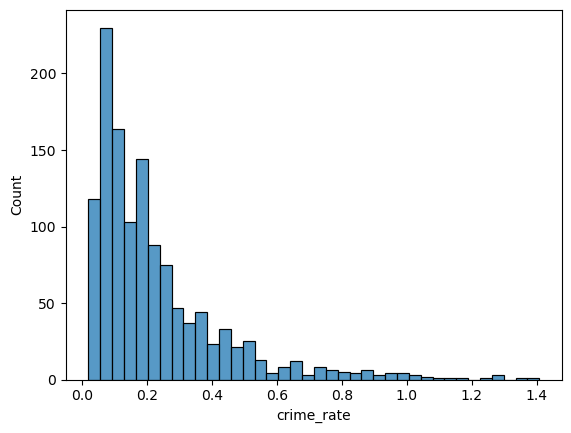

In [19]:
sns.histplot(grouped_df['crime_rate'])

In [11]:
column_data_types = {
   'POPYOUTH1524' : 'float64'  ,
   'POPSENIOR' : 'float64' ,
   'POPMALE1529' : 'float64' ,
   'HIGHRISE' : 'float64' ,
   'SOCIOLONELY' : 'float64' ,
   'LOW_INCOME' : 'float64' ,
   'UNAFFORDABLE_HOUSE' : 'float64' ,
   'INADEQUATE_HOUSE' : 'float64' ,
   'UNSUITABLE_HOUSE' : 'float64' ,
   'DROPOUT' : 'float64' ,
   'UNEMPLOYMENT' : 'float64' ,
   'MALE_UNEMPLOYMENT' : 'float64'
}

for key in column_data_types.keys():
    grouped_df[key] = grouped_df[key].str.strip('%')
    grouped_df[key] = pd.to_numeric(grouped_df[key])

# grouped_df[column_data_types.keys()] = pd.to_numeric(grouped_df[column_data_types.keys()])

# Change the data type of the columns using astype()
# grouped_df = grouped_df.astype(column_data_types)
print(grouped_df.dtypes)

index                    int64
HOOD_140                 int64
OCC_MONTH             category
POPULATION               int64
POPDENSITY               int64
POPYOUTH1524           float64
POPSENIOR              float64
POPMALE1529            float64
HIGHRISE               float64
SOCIOLONELY            float64
LOW_INCOME             float64
UNAFFORDABLE_HOUSE     float64
INADEQUATE_HOUSE       float64
UNSUITABLE_HOUSE       float64
DROPOUT                float64
UNEMPLOYMENT           float64
MALE_UNEMPLOYMENT      float64
count                    int64
dtype: object


In [20]:
results = ols("crime_rate ~ OCC_MONTH + POPULATION + POPDENSITY +POPYOUTH1524 +POPSENIOR +POPMALE1529 +HIGHRISE+SOCIOLONELY+ LOW_INCOME+ UNAFFORDABLE_HOUSE + INADEQUATE_HOUSE + UNSUITABLE_HOUSE + DROPOUT + UNEMPLOYMENT + MALE_UNEMPLOYMENT", data=grouped_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             crime_rate   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     49.63
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          4.50e-166
Time:                        15:42:10   Log-Likelihood:                 620.50
No. Observations:                1246   AIC:                            -1189.
Df Residuals:                    1220   BIC:                            -1056.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

**Try Regression**

In [23]:
categorical_features = ['HOOD_140']
numerical_features = ['POPULATION', 'POPDENSITY', 'POPYOUTH1524', 'POPSENIOR', 'POPMALE1529',
 'HIGHRISE', 'SOCIOLONELY', 'LOW_INCOME', 'UNAFFORDABLE_HOUSE', 'INADEQUATE_HOUSE',
 'UNSUITABLE_HOUSE', 'DROPOUT', 'UNEMPLOYMENT', 'MALE_UNEMPLOYMENT']
target = 'crime_rate'

In [24]:
X_train, X_test, y_train, y_test = train_test_split(grouped_df[categorical_features + numerical_features], grouped_df[target], 
    test_size = 0.3, random_state = 2345)

In [25]:
cat_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
# simple imputer fills missing value with average, KNNImputer, etc
num_transformer = Pipeline(steps = [('scaler', MinMaxScaler())])
# minmax transform the data between 0 and 1

# building processor
preprocessor = ColumnTransformer(transformers = [('cat', cat_transformer, categorical_features),
                                                 ('num', num_transformer, numerical_features)])

In [26]:
ridge_regression = Pipeline(steps = [('preprocessor', preprocessor),
                                      ('regressor', Ridge(alpha = 0.001))
                                      ])
# higher alpha, more penalty
# how to know which hyper param is the best? hyper param tuning
ridge_regression.fit(X_train, y_train)
pred_ridge = ridge_regression.predict(X_test)
print('MSE value: ', np.sqrt(mean_squared_error(pred_ridge, y_test)))
print('R2 value: ', r2_score(pred_ridge, y_test))

MSE value:  0.12372984110694761
R2 value:  0.5275946126794808


In [27]:
lasso_regression = Pipeline(steps = [('preprocessor', preprocessor),
                                      ('regressor', Lasso(alpha = 0.001))
                                      ])
lasso_regression.fit(X_train, y_train)
pred_ridge = lasso_regression.predict(X_test)
print('MSE value: ', np.sqrt(mean_squared_error(pred_ridge, y_test)))
print('R2 value: ', r2_score(pred_ridge, y_test))

MSE value:  0.13898966680371191
R2 value:  0.07174063900785044
